# Linear Wave Equation 2D
### Daniele Fazzari - University of Naples Federico II & Universidad de Granada

The linear wave equation in 2D can be written as follows (where u is the string displacement from the rest position and c is a material dependent constant): 
$$
\begin{align}
\\ \frac{\partial^2 u}{\partial t^2} &= c^2 \nabla^2 u = c^2 \left[ \frac{\partial^2 u}{\partial x^2} +  \frac{\partial^2 u}{\partial y^2} \right]
\end{align}
$$

By approximating the temporal derivative with a backward difference, and the spatial derivative with a central difference, we can discretize the law and thus calculate explicitily the state of the wave at timestep "n+1" (so, for a fixed and finite number of discrete timesteps, we can simulate the behaviour of the 2D wave):
$$
\\ \frac{1}{\Delta t^2} (u_{i, j}^{n+1} - 2u_{i, j}^{n} + u_{i, j}^{n-1}) 
= c \left [
\frac{1}{\Delta x^2}(u_{i-1, j}^n - 2u_{i, j}^n + u_{i+1, j}^n)
+ \frac{1}{\Delta y^2}(u_{i, j-1}^n - 2u_{i, j}^n + u_{i, j+1}^n)
\right] \\
$$
$$
\\ u^{n+1}_{i,j} = 2u_{i,j}^n - u_{i, j}^{n-1}
+ \frac{c\Delta t^2}{\Delta x^2}(u_{i-1, j}^n - 2u_{i, j}^n + u_{i+1, j}^n)
+ \frac{c\Delta t^2}{\Delta y^2}(u_{i, j-1}^n - 2u_{i, j}^n + u_{i, j+1}^n) \\
$$
IMPORTANT - This discretization is unstable if the following CFL condition is not met:
$$
\frac{1}{2} \gt \frac{c\Delta t}{\Delta x^2}, \qquad
\frac{1}{2} \gt \frac{c\Delta t}{\Delta y^2} \\
$$
$$
\Delta t \lt \text{min}\left(\frac{\Delta x^2}{2c}, \frac{\Delta y^2}{2c}\right)
$$

In [1]:
#IMPORTING LIBRARIES 

import pycuda
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import pycuda.autoinit
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
#KERNEL FUNCTION

wave_eqn_kernel_src = """
__global__ void waveEqn2D(float* u2, float* u1, float* u0, float c, float dt, float dx, float dy, int nx, int ny) 
{
    
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    int center = j*nx + i;  
    int north =(j+1)*nx+i;
    int south=(j-1)*nx+i;
    int east=j*nx + (i+1); 
    int west=j*nx + (i-1); 
    
    if(i>0 && i<nx-1 && j>0 && j<ny-1)
    {
        u2[center] = 2.0f*u1[center] - u0[center] 
        + ((c*dt*dt)/(dx*dx)) * (u1[west] - 2.0f*u1[center] + u1[east]) 
        + ((c*dt*dt)/(dy*dy)) * (u1[south]-2.0f*u1[center]+u1[north]);
    }
    
    if (i==0) {
        u1[center] = u1[east];
        u2[center] = u1[east];
    }
    else if (i == nx-1) {
        u1[center] = u1[west];
        u2[center] = u1[west];
    }
    else if (j == 0) {
        u1[center] = u1[north];
        u2[center] = u1[north];
    }
    else if (j == ny-1) {
        u1[center] = u1[south];
        u2[center] = u1[south];
    }
}
"""

mod = SourceModule(wave_eqn_kernel_src)
waveEqnGPU = mod.get_function("waveEqn2D")

In [3]:
#DEFINING PROBLEM PARAMETERS

BLOCK_SIZE_X=4 #x-dimensionality of the blocks
BLOCK_SIZE_Y=4 #y-dimensionality of the blocks
nx=16 #x-dimensionaly of the wave 
ny=16 #y-dimensionaly of the wave
c=1 #c constant of the wave equation
dx=1 #discretization step of the x-dimensionality of the wave
dy=1 #discretization step of the y-dimensionality of the wave
dt=0.4*min(dx*dx / (2.0*c), dy*dy / (2.0*c)) #timestep, calcluted like that to make sure that the evolution of the wave is stable 

In [4]:
#MAIN CPU PROGRAM

def waveEquationGPU(u0,c,dt,dx,dy,num_timesteps):
    
    assert(u0.dtype == np.float32) #assert that we are using single-precision floats
    u2_gpu = cuda.mem_alloc(u0.nbytes) #making space for u1 on GPU memory
    u1_gpu = cuda.mem_alloc(u0.nbytes) #making space for u1 on GPU memory
    u0_gpu = cuda.mem_alloc(u0.nbytes) #making space for u0 on GPU memory
    cuda.memcpy_htod(u0_gpu, u0) #copying u0 initial state vector on GPU memory
    
    block=(BLOCK_SIZE_X, BLOCK_SIZE_Y,1) #computing block size. Bidimensional blocks.
    grid=(int(np.ceil(nx/BLOCK_SIZE_X)),int(np.ceil(ny/BLOCK_SIZE_Y)),1) #computing grid size. Bidimensional grid.
                
    for n in range(num_timesteps): #n is the time-index
        waveEqnGPU(u2_gpu, u1_gpu, u0_gpu, np.float32(c), np.float32(dt), np.float32(dx),np.float32(dy),np.uint32(nx),np.uint32(ny), block=block, grid=grid) 
        u0_gpu, u1_gpu, u2_gpu = u1_gpu, u2_gpu, u0_gpu #instruction to swap the pointers for the next iteration
        
    u_updated = np.empty_like(u0) #reserving space for the updated state of the wave 
    cuda.memcpy_dtoh(u_updated, u2_gpu) #retrieving from GPU memory the updated wave state at timestep n=num_timesteps
    return u_updated #return updated wave state 

In [5]:
#CALLING MAIN CPU PROGRAM

np.random.seed(50) 
initial_state=np.random.rand(nx*ny).astype(np.float32) #initial pseudo-random wave state 

u_tot_1 = waveEquationGPU(u0=initial_state.copy(), c=c,dt=dt,dx=dx,dy=dy,num_timesteps=150)
u_tot_2 = waveEquationGPU(u0=initial_state.copy(), c=c,dt=dt,dx=dx,dy=dy,num_timesteps=500)
u_tot_3 = waveEquationGPU(u0=initial_state.copy(), c=c,dt=dt,dx=dx,dy=dy,num_timesteps=2500)

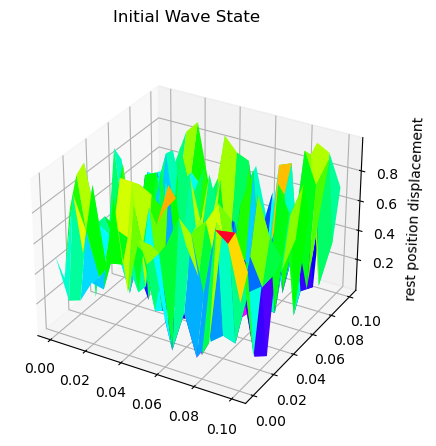

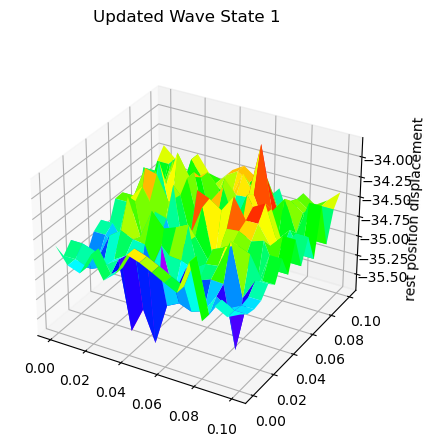

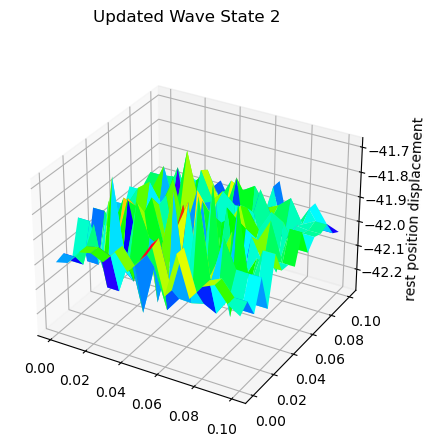

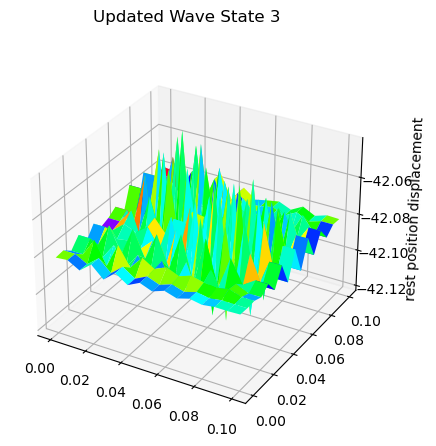

In [6]:
#PlOTTING

updated_state_matrix_1 = u_tot_1.reshape(nx,ny)
updated_state_matrix_2 = u_tot_2.reshape(nx,ny)
updated_state_matrix_3 = u_tot_3.reshape(nx,ny)
initial_state_matrix = initial_state.reshape(nx,ny)

X = np.linspace(0, 0.1, nx, endpoint=True)
Y = np.linspace(0, 0.1, ny, endpoint=True)
X, Y = np.meshgrid(X, Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(X, Y, initial_state_matrix[:,:], cmap = 'gist_rainbow_r', edgecolor = 'none')
ax.set_zlabel('rest position displacement')
fig.suptitle("Initial Wave State")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(X, Y, updated_state_matrix_1[:,:], cmap = 'gist_rainbow_r', edgecolor = 'none')
ax.set_zlabel('rest position displacement')
fig.suptitle("Updated Wave State 1")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(X, Y, updated_state_matrix_2[:,:], cmap = 'gist_rainbow_r', edgecolor = 'none')
ax.set_zlabel('rest position displacement')
fig.suptitle("Updated Wave State 2")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(X, Y, updated_state_matrix_3[:,:], cmap = 'gist_rainbow_r', edgecolor = 'none')
ax.set_zlabel('rest position displacement')
fig.suptitle("Updated Wave State 3")
plt.show()